In [9]:
import re
import os
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as T
from torch.utils.data import Dataset

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from skimage.transform import rescale, resize, downscale_local_mean
from matplotlib import pyplot as plt

DATA_DIR_ROOT_MAIN = "/projects/bk_pca/BK_UBC_CORES"
DATA_DIR_PATCH_ROOT =  "/ssd005/projects/exactvu_pca/bk_ubc/patches/UBC/patch_48x48_str32_avg/"

In [10]:
UBC_CORES = "/projects/bk_pca/BK_UBC_CORES"
QUEENS_CORES = "/projects/bk_pca/BK_QUEENS_CORES"

(2344, 282)


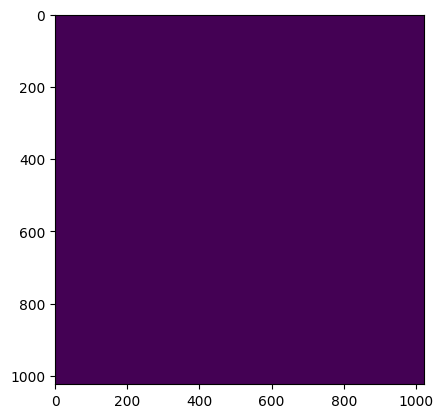

In [20]:
needle = np.load(f'{QUEENS_CORES}/pat2004_cor9_needle.npy')
print(needle.shape)

needle = resize(needle, (1024, 1024))
plt.imshow(needle)

In [41]:
def make_analytical(x):
    from scipy.signal import hilbert
    return np.abs(hilbert(x)) ** 0.3

In [70]:
q_needle = np.load(f'{QUEENS_CORES}/pat2001_cor9_needle.npy')
q_prost = np.load(f'{QUEENS_CORES}/pat2001_cor9_prostate.npy')
q_rf = np.load(f'{QUEENS_CORES}/pat2001_cor9_rf.npy')

In [6]:


q_bmode = make_analytical(q_rf[:, :, -1])

NameError: name 'make_analytical' is not defined

In [72]:
q_needle.shape, q_prost.shape, q_bmode.shape

((1960, 282), (1960, 282), (1960, 282))

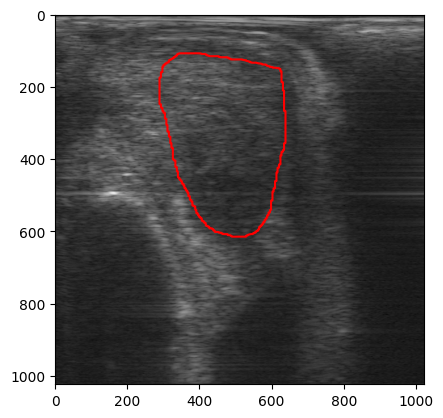

In [73]:
q_bmode = resize(q_bmode, (1024, 1024))
q_needle = resize(q_needle, (1024, 1024))
q_prost = resize(q_prost, (1024, 1024))
masked = q_needle * q_prost

plt.imshow(q_bmode, cmap='gray')
plt.contour(q_prost,  colors='r')
plt.contour(q_needle,  colors='b')
plt.imshow(np.ma.masked_where(masked == 0, masked), alpha=0.8)#, cmap='jet')

In [38]:
df_lensepro_cores = pd.read_csv("lensepro_metadata.csv")

In [39]:
train = df_lensepro_cores[df_lensepro_cores.set == 'train'].id
val = df_lensepro_cores[df_lensepro_cores.set == 'val'].id
test = df_lensepro_cores[df_lensepro_cores.set == 'test'].id

In [45]:
p11_core9_roi = np.load(f'{DATA_DIR_ROOT_MAIN}/pat186_cor3_needle.npy')
p11_core9_wp = np.load(f'{DATA_DIR_ROOT_MAIN}/pat186_cor3_prostate.npy')
p11_core9 = np.load(f'{DATA_DIR_ROOT_MAIN}/pat186_cor3_rf.npy')

In [49]:
p11_core9.shape

(2344, 282, 200)

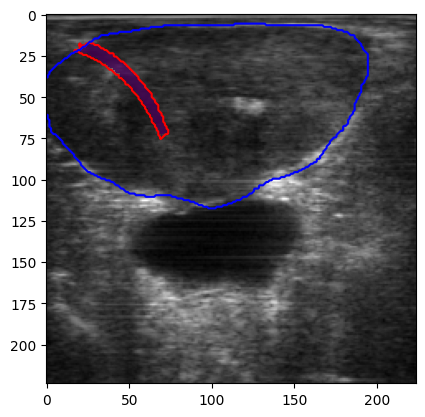

In [52]:
from skimage.transform import rescale, resize, downscale_local_mean
from matplotlib import pyplot as plt

#p11_core9_bmode = make_analytical(p11_core9.mean(axis=-1))
p11_core9_bmode =  make_analytical(p11_core9[:, :, -1])

bmode_1024 = resize(p11_core9_bmode, (224, 224))
roi_1024 = resize(p11_core9_roi, (224, 224))
wp_1024 = resize(p11_core9_wp, (224, 224))
masked = roi_1024 * wp_1024

plt.imshow(bmode_1024, cmap='gray')
plt.contour(roi_1024,  colors='r')
plt.contour(wp_1024,  colors='b')
plt.imshow(np.ma.masked_where(masked == 0, masked), alpha=0.8)#, cmap='jet')

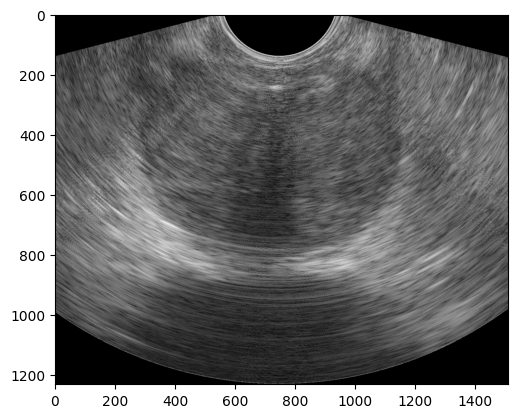

In [12]:
plt.imshow(p11_core9[0], cmap='gray')

In [2]:
from medAI.datasets.data_bk import make_bk_dataloaders

ssl_loader, _, _ = make_bk_dataloaders(self_supervised=True)
train_loader, val_loader, test_loader = make_bk_dataloaders(self_supervised=False)

In [ ]:
os.listdir('')

In [3]:
import re
import os
from glob import glob

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

import numpy as np


class PatchDataset(Dataset):
    def __init__(self, data_dir, transform, pid_range=(0, np.Inf), norm=True, return_idx=True, stats=None,
                 slide_idx=-1, time_series=False, pid_excluded=None, return_prob=False,
                 tta=False, *args, **kwargs):
        super(PatchDataset, self).__init__()
        # self.files = glob(f'{data_dir}/*/*/*/*.npy')
        data_dir = data_dir.replace('\\', '/')
        self.files = glob(f'{data_dir}/*/patches_rf_core/*/*.npy')
        self.transform = transform
        self.pid_range = pid_range
        self.pid_excluded = pid_excluded
        self.norm = norm
        self.pid, self.cid, self.label = [], [], None
        self.attrs = ['files', 'pid', 'cid']
        self.stats = stats
        self.slide_idx = slide_idx
        self.time_series = time_series
        self.return_idx = return_idx
        self.return_prob = return_prob
        self.probability = None
        self.tta = tta  # test time augmentation

    def extract_metadata(self):
        for file in self.files:
            self.pid.append(int(re.findall('/Patient(\d+)/', file)[0]))
            self.cid.append(int(re.findall('/core(\d+)', file)[0]))
        for attr in self.attrs:  # convert to array
            setattr(self, attr, np.array(getattr(self, attr)))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = np.load(self.files[idx], mmap_mode='c').astype('float32')

        if self.transform is not None:
            data = self.transform(data)
        if self.time_series:
            data = F.avg_pool2d(torch.tensor(data), kernel_size=(8, 8), stride=8).flatten(1).T
            if self.norm:
                data = (data - np.median(data)) / (np.percentile(data, 75) - np.percentile(data, 25))
        if self.norm and not self.time_series:
            if isinstance(data, tuple) or isinstance(data, list):
                data = tuple(self.norm_data(d) for d in data)
            else:
                data = self.norm_data(data)
            data = (data - np.median(data)) / (np.percentile(data, 75) - np.percentile(data, 25))

        if self.tta:
            data = np.concatenate([data, np.flip(data, axis=-1)], axis=0)

        if self.label is not None:
            label = self.label[idx]
            if self.return_prob:
                assert self.probability is not None
                return data, label, self.probability[idx]
            if self.return_idx:
                return data, label, idx
            return data, label

        return data[0], data[1]

    def norm_data(self, data):
        if self.stats is not None:
            data = (data - self.stats[0]) / self.stats[1]
        else:
            data = (data - data.mean()) / data.std()
        return data

    def filter_by_pid(self):
        idx = np.logical_and(self.pid >= self.pid_range[0], self.pid <= self.pid_range[1])
        if self.pid_excluded is not None:
            idx[np.isin(self.pid, self.pid_excluded)] = False
        self.filter_by_idx(idx)

    def filter_by_idx(self, idx):
        for attr in self.attrs:
            if getattr(self, attr) is not None:
                setattr(self, attr, getattr(self, attr)[idx])


class PatchLabeledDataset(PatchDataset):
    def __init__(self, data_dir, transform=None, pid_range=(0, np.Inf), inv_range=(0, 1), gs_range=(7, 10),
                 queens_data=False, file_idx=None, oversampling_cancer=False, *args, **kwargs):
        super().__init__(data_dir, transform, pid_range, *args, **kwargs)
        self.inv_range = inv_range
        self.gs_range = gs_range
        self.attrs.extend(['label', 'gs', 'location', 'id', 'inv'])
        self.label, self.inv, self.gs, self.location, self.id = [[] for _ in range(5)]
        self.queens_data = queens_data

        oversampling_dict = {0.8: 22, 0.7: 17, 0.6: 11, 0.5: 7, 0.4: 6}
        if oversampling_cancer:
            oversampling_rate = oversampling_dict[min(self.inv_range)]
            # the oversampling rate (17) is calculated based on the class ratio after all filtering steps
            oversampled_files = []
            for file in self.files:
                if '_cancer' in file:
                    oversampled_files.extend([file for _ in range(oversampling_rate)])
            self.files += oversampled_files

        self.extract_metadata()
        self.filter_by_pid()
        self.filter_by_inv()
        self.filter_by_gs()
        if file_idx is not None:
            self.filter_by_idx(file_idx)

    def extract_metadata(self):
        for file in self.files:
            folder_name = os.path.basename(os.path.dirname(file))
            self.label.append(0) if folder_name.split('_')[1] == 'benign' else self.label.append(1)
            self.location.append(folder_name.split('_')[-2])
            self.inv.append(float(re.findall('_inv([\d.[0-9]+)', file)[0]))
            self.gs.append(int(re.findall('_gs(\d+)', file)[0]))
            self.pid.append(int(re.findall('/Patient(\d+)/', file)[0]))
            self.cid.append(int(re.findall('/core(\d+)_', file)[0]))
            self.id.append(int(folder_name.split('_')[-1][2:]))
        for attr in self.attrs:  # convert to array
            setattr(self, attr, np.array(getattr(self, attr)))

    def filter_by_inv(self):
        idx = np.logical_and(self.inv >= self.inv_range[0], self.inv <= self.inv_range[1])
        idx = np.logical_or(idx, self.inv == 0)
        self.filter_by_idx(idx)

    def filter_by_gs(self):
        idx = np.logical_and(self.gs >= self.gs_range[0], self.gs <= self.gs_range[1])
        idx = np.logical_or(idx, self.gs == 0)
        self.filter_by_idx(idx)


class PatchUnlabeledDataset(PatchDataset):
    def __init__(self, data_dir, transform=None, pid_range=(0, np.Inf), stats=None, norm=True, *args, **kwargs):
        super(PatchUnlabeledDataset, self).__init__(data_dir, transform, pid_range, norm=norm)
        # Note: cid: per patient core id; id: absolute core id
        self.extract_metadata()
        self.filter_by_pid()


class CropFixSize:
    def __init__(self, sz=32, in_channels=1):
        import imgaug.augmenters as iaa
        self.in_channels = in_channels
        self.seq = iaa.CenterCropToFixedSize(sz, sz)

    def __call__(self, sample):

        if (sample.ndim > 2) and (sample.shape[-1] > 1):
            assert sample.shape[-1] >= self.in_channels
            sample = sample[..., :self.in_channels]

        x1 = self.seq(image=sample)

        if x1.ndim > 2:
            return x1.transpose([2, 0, 1])
        return x1[np.newaxis]

In [4]:
data_dir_root = "/ssd005/projects/exactvu_pca/bk_ubc/"

In [13]:
def get_labels():
    data_dir = "/ssd005/projects/exactvu_pca/bk_ubc/patches/UBC/patch_48x48_str32_avg/"
    patients = {}
    for patient in os.listdir(data_dir):
        cores = []
        try:
            for core in os.listdir(data_dir + str(patient) + "/patches_rf_core"):
                cores.append(1 if "cancer" in core else 0)
            patients[patient] = cores
        except FileNotFoundError:
            continue

    return patients

def build_label_table():
    df = pd.DataFrame()
    for key, value in get_labels().items():
        for i in range(len(value)):
            k = key.replace("Patient", "Pa")
            row = pd.DataFrame({"core_id": [k+"_00"+str(i)], "patient_id": [k], "label": [value[i]]})
            df = pd.concat([df, row], ignore_index=True)
    return df

In [15]:
o = build_label_table()
patient_table = o[["patient_id", "core_id"]].drop_duplicates(subset=["patient_id"])

In [19]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(patient_table, test_size=0.3, random_state=42)
val, test = train_test_split(val, test_size=0.5, random_state=42)

assert set(train.patient_id) & set(val.patient_id) == set()
assert set(val.patient_id) & set(test.patient_id) == set()
assert set(train.patient_id) & set(test.patient_id) == set()

In [22]:
o[o.patient_id.isin(train.patient_id)]

,core_id,patient_id,label
9,Pa164_000,Pa164,0
10,Pa164_001,Pa164,0
11,Pa164_002,Pa164,0
12,Pa164_003,Pa164,0
13,Pa164_004,Pa164,0
...,...,...,...
942,Pa27_008,Pa27,0
943,Pa65_000,Pa65,0
944,Pa65_001,Pa65,0
945,Pa65_002,Pa65,0


In [7]:
def build_core_dataset():
    data_dir_root = "/ssd005/projects/exactvu_pca/bk_ubc/npy"
    for patient in os.listdir(data_dir_root):
        patient_dir = os.path.join(data_dir_root, patient)
        print(patient_dir)
        for core in os.listdir(patient_dir):
            core_dir = os.path.join(patient_dir, core)
            print(core_dir)
            data = np.load(core_dir)
            print(data.shape)
            print(data.dtype)
            print(data[0,0,0])
            break
        break

In [8]:
os.listdir("/ssd005/projects/exactvu_pca/bk_ubc/npy_bmode/Patient11/")

['Core5.png',
 'Core5.npy',
 'Core7.png',
 'Core4.npy',
 'Core9.png',
 'Core1.npy',
 'Core7.npy',
 'Core3.png',
 'Core0.png',
 'Core3.npy',
 'Core1.png',
 'Core2.png',
 'Core4.png',
 'Core0.npy',
 'Core2.npy',
 'Core9.npy']

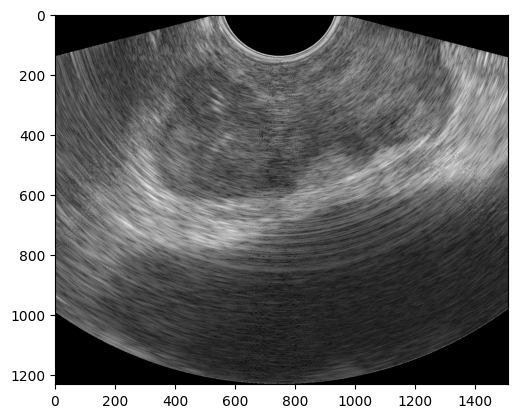

In [9]:
d=np.load("/ssd005/projects/exactvu_pca/bk_ubc/npy_bmode/Patient11/Core0.npy")
plt.imshow(d.astype(float)[0,:,:], cmap='gray')

In [10]:
p = PatchLabeledDataset("/ssd005/projects/exactvu_pca/bk_ubc/patches/UBC/patch_48x48_str32_avg/")
p.label.shape

(17154,)

In [11]:
a  = np.load("/ssd005/projects/exactvu_pca/bk_ubc/patches/UBC/patch_48x48_str32_avg/Patient11/patches_rf_core/core0_cancer_gs9_inv1.0_RBL_id102/patch10_r312_c80.npy")
a.shape

(48, 48)

In [12]:
import torch
from medAI.modeling.resnet import resnet32

r = resnet32()
r(torch.from_numpy(a).unsqueeze(1).float())

tensor([[1.4558, 1.2122, 1.2717,  ..., 1.0137, 2.6672, 1.3899],
        [2.6247, 2.2807, 6.4056,  ..., 3.4805, 5.8983, 3.6710],
        [4.3066, 2.9918, 6.9212,  ..., 4.4837, 7.2600, 5.2480],
        ...,
        [0.6724, 0.5901, 0.6644,  ..., 0.3948, 0.3653, 0.5259],
        [0.6730, 0.4220, 0.6850,  ..., 0.7538, 0.4234, 0.7840],
        [0.6119, 0.3905, 0.4288,  ..., 0.4070, 0.3179, 0.4844]],
       grad_fn=<ViewBackward0>)